# Rating Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from collections import defaultdict, Counter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
Rating=pd.read_csv('Rating_Reviews.csv',encoding='latin-1')
Rating.head()

,Unnamed: 0,Ratings,Full_review
0,0,5,Its an absolute beast if u know what are the n...
1,1,5,This is the best laptop in this range.I reciev...
2,2,5,Good product as used of now.... Everything is ...
3,3,5,AWESOME LAPTOP. It supports many high spec gam...
4,4,4,For that price... it's exceptionally good. Pla...


In [3]:
#dropping the Unnamed: 0 column
Rating.drop('Unnamed: 0', axis =1, inplace = True)

In [4]:
print('shape = >',Rating.shape)

shape = > (36346, 2)


In [5]:
print('Rating counts','\n',Rating.Ratings.value_counts())

Rating counts 
 5    19739
4     6881
1     5250
3     2950
2     1526
Name: Ratings, dtype: int64


# Observation

In [6]:
def plot_labels(Rating, title=None):
  ds_labels = Rating["Ratings"].value_counts(normalize=True)
  ds_labels.sort_index(inplace=True)
  plt.figure(figsize=(4,3))
  ax = ds_labels.plot(kind="bar")
  ax.set_xlabel("Stars")
  ax.set_ylabel("Ratio")
  if title is not None:
    plt.savefig(title + ".eps")
  plt.show()

# We can observe that the dataset is imbalanced.

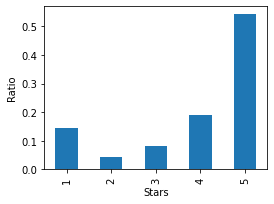

In [7]:
plot_labels(Rating, "stars")

In [8]:
Rating['length']=Rating.Full_review.str.len()
Rating.head()

,Ratings,Full_review,length
0,5,Its an absolute beast if u know what are the n...,500
1,5,This is the best laptop in this range.I reciev...,500
2,5,Good product as used of now.... Everything is ...,271
3,5,AWESOME LAPTOP. It supports many high spec gam...,96
4,4,For that price... it's exceptionally good. Pla...,342


# Here we create another column length based on the length of reviews.

In [9]:
Rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36346 entries, 0 to 36345
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Ratings      36346 non-null  int64 
 1   Full_review  36346 non-null  object
 2   length       36346 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 852.0+ KB


In [10]:
Rating.isnull().sum()

Ratings        0
Full_review    0
length         0
dtype: int64

<AxesSubplot:>

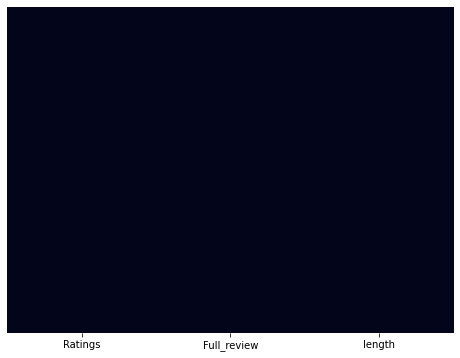

In [11]:
#Visualizing missing values if any through heatmap
plt.figure(figsize=(8,6))
sns.heatmap(Rating.isnull(),yticklabels=False,cbar=False)

Observation:
Thus we confirm that there are no missing values present in our dataset.

In [12]:
#convert text to lowercase
Rating['Full_review']=Rating['Full_review'].str.lower()

In [13]:
Rating['Full_review']=Rating['Full_review'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')

Rating['Full_review']=Rating['Full_review'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')

Rating['Full_review']=Rating['Full_review'].str.replace(r'£|\$', 'dollers')

Rating['Full_review']=Rating['Full_review'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phonenumber')

Rating['Full_review']=Rating['Full_review'].str.replace(r'\d+(\.\d+)?', 'numbr')

In [14]:
#remove punctuation
Rating['Full_review']=Rating['Full_review'].str.replace(r'[^\w\d\s]', ' ')

#replace whitespace between terms with a single space
Rating['Full_review']=Rating['Full_review'].str.replace(r'\s+', ' ')

#Remove leading and trailing whitespace
Rating['Full_review']=Rating['Full_review'].str.replace(r'^\s+|\s+?$', '')

In [15]:
Rating.head()

,Ratings,Full_review,length
0,5,its an absolute beast if u know what are the n...,500
1,5,this is the best laptop in this range i reciev...,500
2,5,good product as used of now everything is good...,271
3,5,awesome laptop it supports many high spec game...,96
4,4,for that price it s exceptionally good played ...,342


In [16]:
#Remove stopwords
import string
import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english') + ['u', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])

Rating['Full_review'] = Rating['Full_review'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

In [17]:
Rating['clean_length'] = Rating.Full_review.str.len()

In [18]:
Rating.head()

,Ratings,Full_review,length,clean_length
0,5,absolute beast know necessary steps follow com...,500,294
1,5,best laptop range recieved late delivery due b...,500,337
2,5,good product used everything good also ssd slo...,271,150
3,5,awesome laptop supports many high spec games l...,96,84
4,4,price exceptionally good played far cry numbr ...,342,254


In [19]:
print('original Review length', Rating.length.sum())
print('clean Review length', Rating.clean_length.sum())

original Review length 2245679
clean Review length 1593971


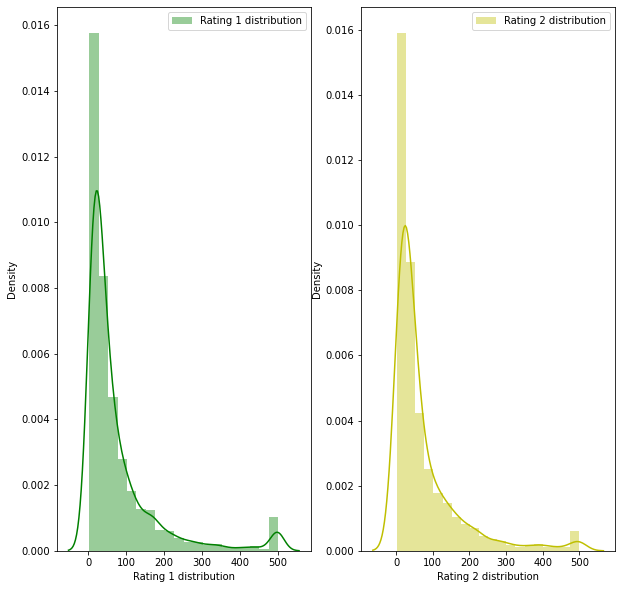

In [20]:
#message distribution before cleaning

f,ax = plt.subplots(1,2,figsize=(10,10))

sns.distplot(Rating[Rating['Ratings']==1]['length'],bins=20,ax=ax[0],label='Rating 1 distribution',color='g')
ax[0].set_xlabel('Rating 1 distribution')
ax[0].legend()

sns.distplot(Rating[Rating['Ratings']==2]['length'],bins=20,ax=ax[1],label='Rating 2 distribution',color='y')
ax[1].set_xlabel('Rating 2 distribution')
ax[1].legend()

plt.show()

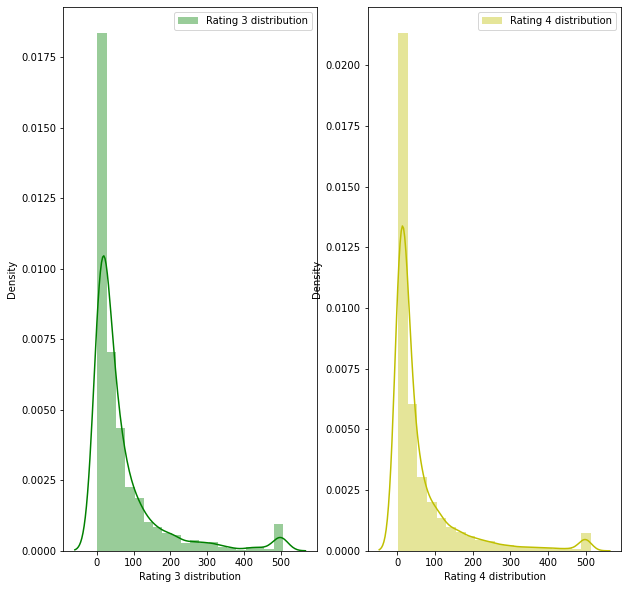

In [21]:
f,ax = plt.subplots(1,2,figsize=(10,10))

sns.distplot(Rating[Rating['Ratings']==3]['length'],bins=20,ax=ax[0],label='Rating 3 distribution',color='g')
ax[0].set_xlabel('Rating 3 distribution')
ax[0].legend()

sns.distplot(Rating[Rating['Ratings']==4]['length'],bins=20,ax=ax[1],label='Rating 4 distribution',color='y')
ax[1].set_xlabel('Rating 4 distribution')
ax[1].legend()

plt.show()

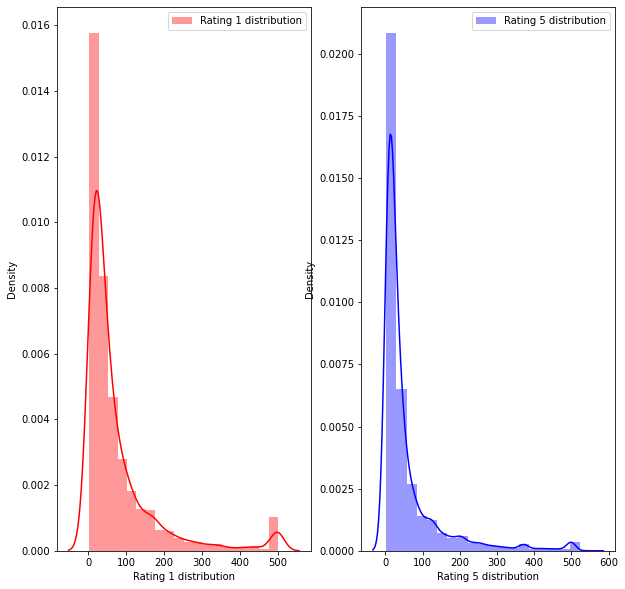

In [22]:
f,ax = plt.subplots(1,2,figsize=(10,10))

sns.distplot(Rating[Rating['Ratings']==1]['length'],bins=20,ax=ax[0],label='Rating 1 distribution',color='r')
ax[0].set_xlabel('Rating 1 distribution')
ax[0].legend()

sns.distplot(Rating[Rating['Ratings']==5]['length'],bins=20,ax=ax[1],label='Rating 5 distribution',color='b')
ax[1].set_xlabel('Rating 5 distribution')
ax[1].legend()

plt.show()

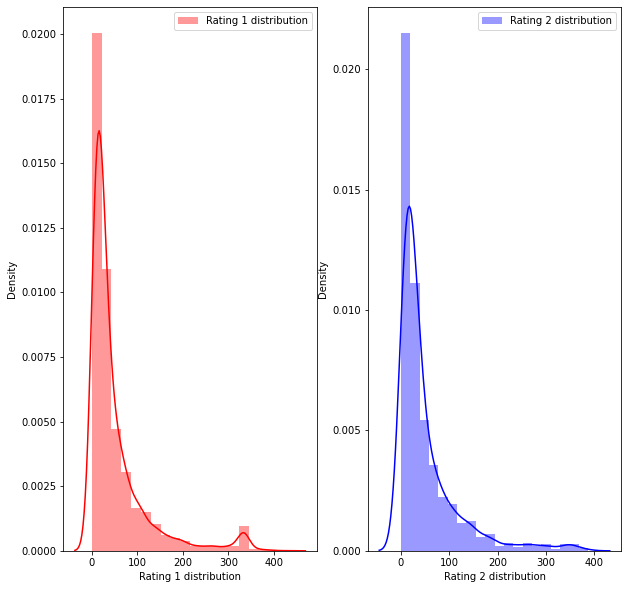

In [23]:
#message distribution after cleaning

f,ax = plt.subplots(1,2,figsize=(10,10))

sns.distplot(Rating[Rating['Ratings']==1]['clean_length'],bins=20,ax=ax[0],label='Rating 1 distribution',color='r')
ax[0].set_xlabel('Rating 1 distribution')
ax[0].legend()

sns.distplot(Rating[Rating['Ratings']==2]['clean_length'],bins=20,ax=ax[1],label='Rating 2 distribution',color='b')
ax[1].set_xlabel('Rating 2 distribution')
ax[1].legend()

plt.show()

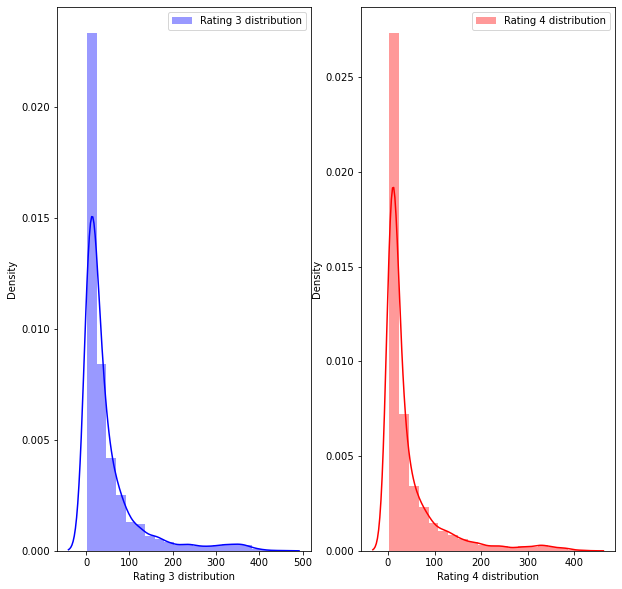

In [24]:
f,ax = plt.subplots(1,2,figsize=(10,10))

sns.distplot(Rating[Rating['Ratings']==3]['clean_length'],bins=20,ax=ax[0],label='Rating 3 distribution',color='b')
ax[0].set_xlabel('Rating 3 distribution')
ax[0].legend()

sns.distplot(Rating[Rating['Ratings']==4]['clean_length'],bins=20,ax=ax[1],label='Rating 4 distribution',color='r')
ax[1].set_xlabel('Rating 4 distribution')
ax[1].legend()

plt.show()

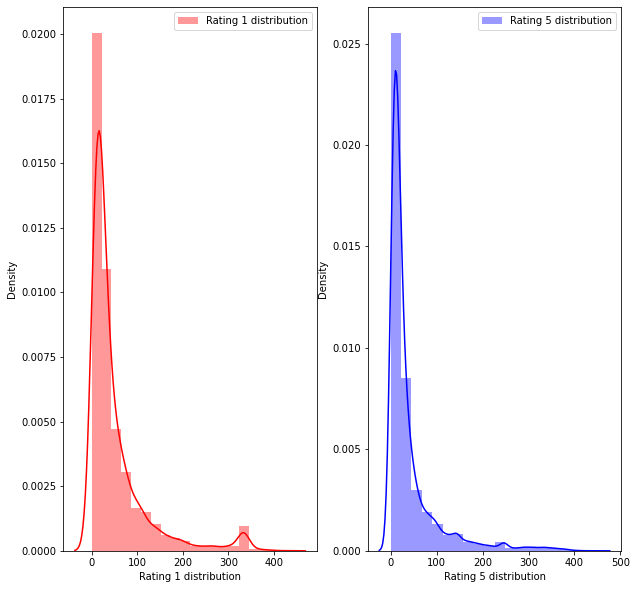

In [25]:
f,ax = plt.subplots(1,2,figsize=(10,10))

sns.distplot(Rating[Rating['Ratings']==1]['clean_length'],bins=20,ax=ax[0],label='Rating 1 distribution',color='r')
ax[0].set_xlabel('Rating 1 distribution')
ax[0].legend()

sns.distplot(Rating[Rating['Ratings']==5]['clean_length'],bins=20,ax=ax[1],label='Rating 5 distribution',color='b')
ax[1].set_xlabel('Rating 5 distribution')
ax[1].legend()

plt.show()

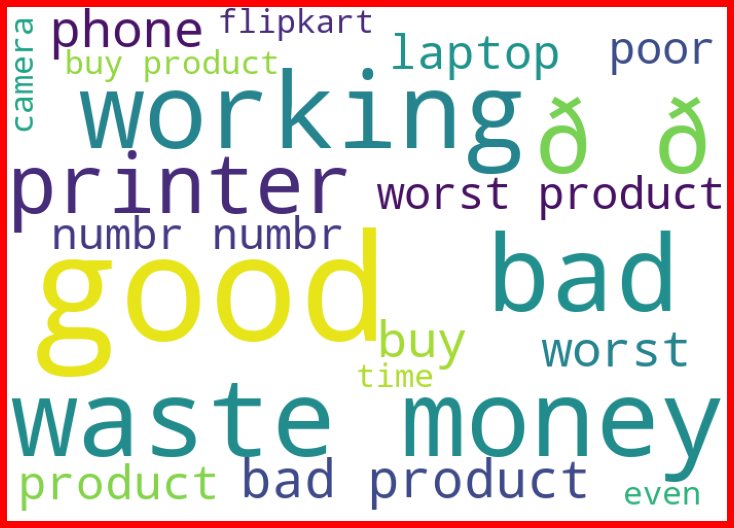

In [27]:
#getting sense of review Loud words in Rating 1
from wordcloud import WordCloud

Rating1=Rating['Full_review'][Rating['Ratings']==1]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(Rating1))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

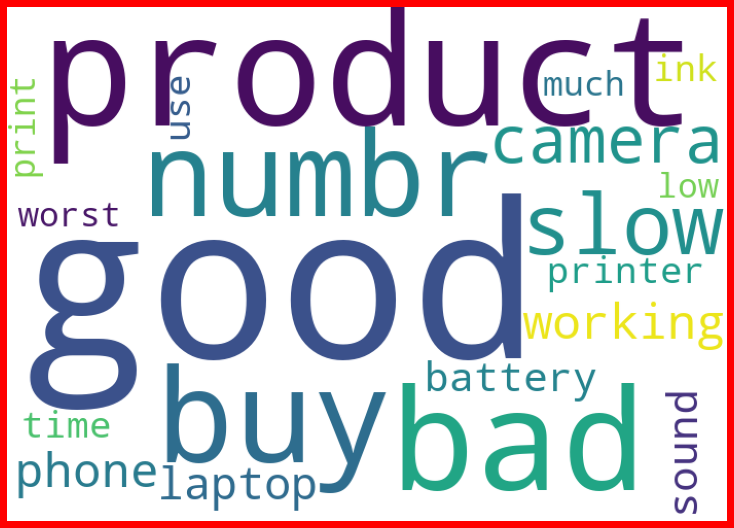

In [28]:
#getting sense of review Loud words in Rating 2

Rating2=Rating['Full_review'][Rating['Ratings']==2]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(Rating2))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

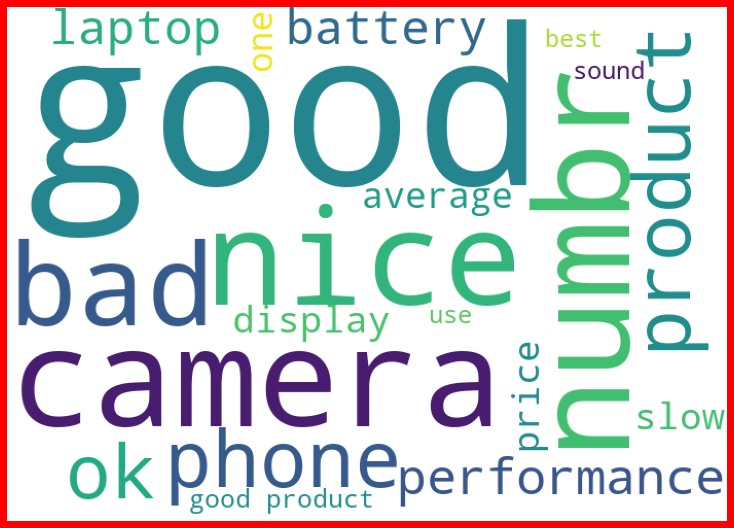

In [29]:
#getting sense of review Loud words in Rating 3

Rating3=Rating['Full_review'][Rating['Ratings']==3]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(Rating3))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

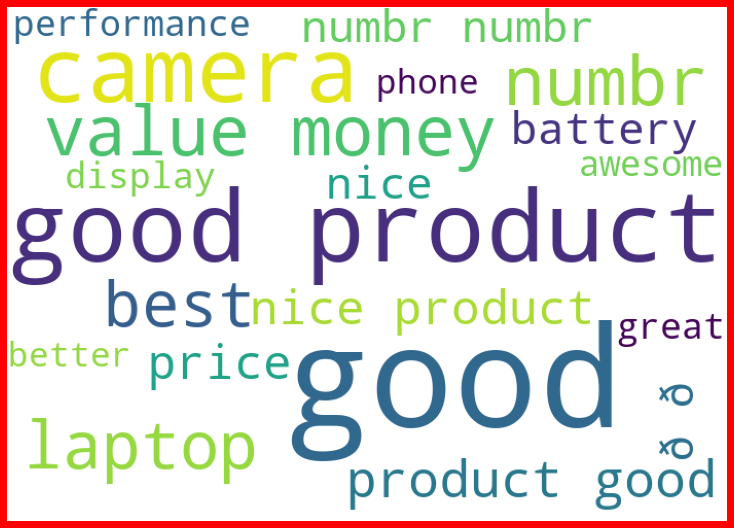

In [30]:
#getting sense of review Loud words in Rating 4

Rating4=Rating['Full_review'][Rating['Ratings']==4]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(Rating4))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

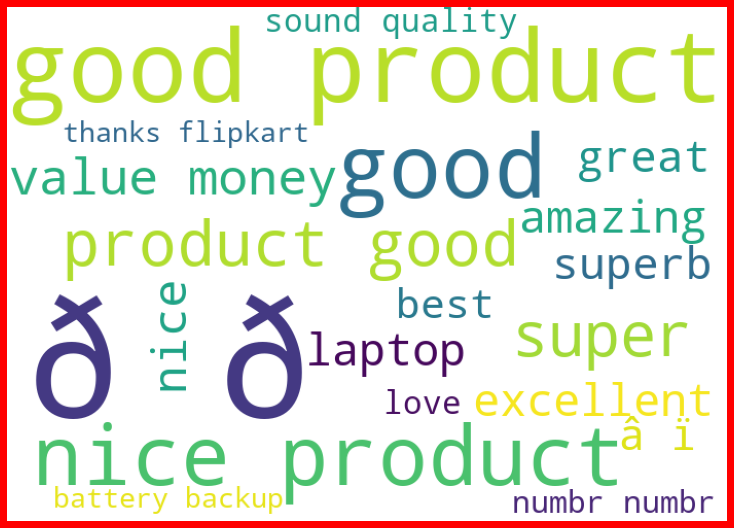

In [31]:
#getting sense of review Loud words in Rating 5

Rating5=Rating['Full_review'][Rating['Ratings']==5]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(Rating5))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vec=TfidfVectorizer()
feature1=tf_vec.fit_transform(Rating['Full_review'])

In [33]:
x=feature1

In [34]:
y=Rating['Ratings']

# Modeling

In [35]:
#splitting the data into training and testing data

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=9)

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [37]:
lr = LogisticRegression()
gnb=GaussianNB()
knc = KNeighborsClassifier()
dtc = DecisionTreeClassifier()
svc = SVC()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()

In [38]:
model=[lr,knc,dtc,svc,rf,ada,gnb]
for m in model:
    print('The model is: ',m)
    m.fit(x_train,y_train)
    predict=m.predict(x_test)
    pred_train=m.predict(x_train)
    print('Accuracy score for the training : ',accuracy_score(y_train,pred_train))
    print('Accuracy score for the model is: ',accuracy_score(y_test,predict))
    print('Calssification Report is: ',classification_report(y_test,predict))
    print('Confusion Matrix is: ',confusion_matrix(y_test,predict))
    print('\n\n')

The model is:  LogisticRegression()
Accuracy score for the training :  0.7014032191498143
Accuracy score for the model is:  0.6530949105914718
Calssification Report is:                precision    recall  f1-score   support

           1       0.68      0.78      0.72      1033
           2       0.15      0.01      0.03       268
           3       0.37      0.14      0.21       594
           4       0.39      0.11      0.17      1427
           5       0.68      0.94      0.79      3948

    accuracy                           0.65      7270
   macro avg       0.45      0.40      0.38      7270
weighted avg       0.58      0.65      0.58      7270

Confusion Matrix is:  [[ 802   12   19   23  177]
 [ 142    4   29   15   78]
 [ 113    5   86   76  314]
 [  53    4   58  159 1153]
 [  72    1   39  139 3697]]



The model is:  KNeighborsClassifier()
Accuracy score for the training :  0.6641903975787591
Accuracy score for the model is:  0.5693259972489684
Calssification Report is:     

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
model = [lr, knc, dtc, svc, rf, ada, gnb]
for m in model:
    print('The model is: \n',m)
    for j in range (2,10):
        train_accuracy = accuracy_score(y_train, pred_train)
        test_accuracy = accuracy_score(y_test, predict)
        cv_score = cross_val_score(m, x, y, cv = j)
        cv_mean = cv_score.mean()
        print(f'At cross fold {j} the cv score is {cv_mean}')
        print('\n\n')

The model is: 
 LogisticRegression()
At cross fold 2 the cv score is 0.6238650745611621



At cross fold 3 the cv score is 0.6229570359910147



At cross fold 4 the cv score is 0.6222686257512038



At cross fold 5 the cv score is 0.6191871380850223



At cross fold 6 the cv score is 0.6283215890476953



At cross fold 7 the cv score is 0.62482785331462



At cross fold 8 the cv score is 0.6277715830324785



At cross fold 9 the cv score is 0.6309616836526275



The model is: 
 KNeighborsClassifier()
At cross fold 2 the cv score is 0.5337588730534308



At cross fold 3 the cv score is 0.5438564868489818



At cross fold 4 the cv score is 0.5044015355174153



At cross fold 5 the cv score is 0.49961384129586495



At cross fold 6 the cv score is 0.5367025209811657



At cross fold 7 the cv score is 0.5383804240617682



At cross fold 8 the cv score is 0.5334564627266681



At cross fold 9 the cv score is 0.5396479313213148



The model is: 
 DecisionTreeClassifier()
At cross fold 2 the 

KeyboardInterrupt: 

Using gridsearch cv to find the best parameters in random forest

In [41]:
from sklearn.model_selection import GridSearchCV

In [42]:
param = {'criterion':['gini', 'entropy'],'splitter':['best', 'random'],'max_features':['log2','auto','sqrt']}

In [43]:
modeldtr = DecisionTreeClassifier()

In [44]:
grids = GridSearchCV(modeldtr,param,cv=4)

In [45]:
grid_result = grids.fit(x_train, y_train)

In [46]:
print(grids.best_params_)

{'criterion': 'entropy', 'max_features': 'auto', 'splitter': 'best'}


In [47]:
print('Best Score: ', grid_result.best_score_)

Best Score:  0.5792406108130417


In [48]:
dtr=DecisionTreeClassifier(criterion='entropy',max_features='auto',splitter='best')

In [49]:
dtr.fit(x_train, y_train)
dtr.score(x_train, y_train)
preddtr = dtr.predict(x_test)
data = [preddtr, y_test]
pd.DataFrame(data, index = ['Predicted', 'Actual'])

,0,1,2,3,4,5,6,7,8,9,...,7260,7261,7262,7263,7264,7265,7266,7267,7268,7269
Predicted,5,5,1,5,5,1,5,5,5,5,...,5,5,1,1,1,1,5,5,3,5
Actual,1,4,5,5,5,1,5,4,4,4,...,5,5,2,1,1,5,5,5,3,4


In [50]:
print('Errors:')
print('\n')
print('Accuracy score for the training : ',accuracy_score(y_train,pred_train))
print('Accuracy score for the model is: ',accuracy_score(y_test,predict))
print('Calssification Report is: ',classification_report(y_test,predict))
print('Confusion Matrix is: ',confusion_matrix(y_test,predict))
print('\n\n')

Errors:


Accuracy score for the training :  0.6354037694318339
Accuracy score for the model is:  0.6275103163686382
Calssification Report is:                precision    recall  f1-score   support

           1       0.66      0.66      0.66      1033
           2       0.20      0.00      0.01       268
           3       0.34      0.11      0.16       594
           4       0.33      0.02      0.04      1427
           5       0.64      0.96      0.76      3948

    accuracy                           0.63      7270
   macro avg       0.43      0.35      0.33      7270
weighted avg       0.54      0.63      0.53      7270

Confusion Matrix is:  [[ 677    1   14    6  335]
 [ 118    1   21    4  124]
 [  99    2   64   16  413]
 [  51    0   46   32 1298]
 [  79    1   41   39 3788]]





In [54]:
# Saving our model

In [55]:
import joblib

In [56]:
joblib.dump(lr,'ratings_preddtr.obj')

['ratings_preddtr.obj']

In [58]:
model=joblib.load('ratings_preddtr.obj')